# Dashboard

## Setup

### Load base config and modules

In [1]:
from base_config import *
from base_functions import *

## Print Environment

In [2]:
get_ipython().run_line_magic('load_ext', 'watermark')  # noqa
get_ipython().run_line_magic('watermark', '-a "Silvan Zahno" -d -v -iv -m -h')  # noqa

json       2.0.9
matplotlib 3.1.3
seaborn    0.10.0
re         2.2.1
plotly     4.5.4
pytz       2019.3
numpy      1.18.1
watermark  2.0.2
pandas     1.0.1
Silvan Zahno 2020-04-02 

CPython 3.7.6
IPython 7.12.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : zell


### Configuration

In [3]:
# Setup local input directories
inputDir = data_inputDir + os.sep
createDir(inputDir, verbose)

In [4]:
# Setup local output directories
outputDir = data_outputDir + os.sep

md_subdir = "md" + os.sep

outputMdDir = outputDir + md_subdir

createDir(os.path.realpath(outputDir))
createDir(os.path.realpath(outputMdDir))

## Data Import

### Read ProjectList  Data

In [5]:
projectDf = pd.read_excel(projectListFile)
# Convert to datetime
projectDf[projectCol["date_begin"]] =  pd.to_datetime(projectDf[projectCol["date_begin"]], format='%d.%m.%Y')
projectDf[projectCol["date_end"]] =  pd.to_datetime(projectDf[projectCol["date_end"]], format='%d.%m.%Y')

# Calculate duration
projectDf['duration'] = projectDf[projectCol["date_end"]] - projectDf[projectCol["date_begin"]]
projectDf['duration_month'] = year2month* (projectDf[projectCol["date_end"]].dt.year - projectDf[projectCol["date_begin"]].dt.year) + (projectDf[projectCol["date_end"]].dt.month - projectDf[projectCol["date_begin"]].dt.month + (projectDf[projectCol["date_end"]].dt.day - projectDf[projectCol["date_begin"]].dt.day)*day2month)
projectCol['duration'] = "duration"
projectCol['duration_month'] = "duration_month"

# Fill not existent budgets with 0
projectDf['budget_total'].fillna(0, inplace=True)
projectDf['budget_material'].fillna(0, inplace=True)
projectDf['budget_extern'].fillna(0, inplace=True)
if verbose >= 1:
  display(projectDf)

,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
0,100092,P3-USP,P3 - Unique Stability Plate,P3 - prime soutien Inno 2019 - USP,0.0,0.0,0.0,NaT,NaT,01.04.2020,NaT,NaN
1,99904,P3-GAE,P3 - Groundbreaking Aluminium Extrusion,P3 - prime soutien Inno 2019 - Groundbreaking,0.0,0.0,0.0,NaT,NaT,01.04.2020,NaT,NaN
2,99903,P3-DT,P3 - Dynamic Production Planning with Digital ...,P3 - prime soutein Inno 2019 - Dynamic,15000.0,0.0,0.0,2019-11-01,2020-12-18,01.04.2020,413 days,13.558522
3,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,0.0,2019-11-01,2020-10-31,01.04.2020,365 days,11.985626
4,96201,USP,Unique Stability Plate,USP - Innosuisse No 35311.1 IP-ENG,353674.0,0.0,105458.0,2019-05-01,2020-10-31,01.04.2020,549 days,17.985626
5,95594,SPL-Filiere,SPL Filiere,Lab Smart Process CONSTELLIUM - Filière,156640.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626
6,95145,SPL-PPI,SPL Personal Development,Lab Smart Process CONSTELLIUM - PPI,173359.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626
7,89403,SPL-Base,SPL Base,Smart Process LAb CONSTELLIUM,507577.0,1233.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


### Read Project Data

In [6]:
files = listDir(inputDir, verbose)

Files from directory  in\


In [7]:
sageXDfs = []
projectConfs = []

for file in files:
  file = inputDir + os.sep + file

  # Get Project ID
  filename = os.path.basename(file)
  filename = os.path.splitext(filename)[0]
  projectId = re.search('([0-9]*)', filename).groups()[0]

  # Read Excel
  sageXDf = pd.read_excel(file)

  # Remove the last two Rows (Total and empty row)
  sageXDf.drop(sageXDf.tail(2).index,inplace=True)

  # Detect Language
  if sageXDf.columns[0] == ashCols['german']['date']:
    lang = 'german'
  else:
    lang = 'french'

  # Convert Date to Datetime
  sageXDf[ashCols[lang]['date']] =  pd.to_datetime(sageXDf[ashCols[lang]['date']], format='%d.%m.%Y')

  # Display
  if verbose >= 2:
    print("Project Id: " +  projectId)
    print("Language: " + lang)
    display(sageXDf)
  
  sageXDfs.append(sageXDf)
  projectConfs.append([projectId, lang])
display(projectConfs)

[['89403', 'german'],
 ['95145', 'german'],
 ['95594', 'german'],
 ['96201', 'german'],
 ['98568', 'german'],
 ['98568', 'french'],
 ['99903', 'german']]

## Calculations

### Add Total and Monthly Budget

In [8]:
dfs = sageXDfs
for i in range(len(projectConfs)):
  projectConf = projectConfs[i]
  df = dfs[i]
  ash_col = ashCols[projectConf[1]]
  ashCols[projectConf[1]]['total_budget'] = 'Total Budget'
  df['Total Budget'] = filterRows(projectDf, [projectCol["project_number"], [projectConf[0]]])[projectCol["budget_total"]].iloc[0] - filterRows(projectDf, [projectCol["project_number"], [projectConf[0]]])[projectCol["budget_material"]].iloc[0] - filterRows(projectDf, [projectCol["project_number"], [projectConf[0]]])[projectCol["budget_extern"]].iloc[0]
  monthly_budget = df['Total Budget'].iloc[0]/filterRows(projectDf, [projectCol["project_number"], [projectConf[0]]])[projectCol['duration_month']].iloc[0]
  
  ashCols[projectConf[1]]['monthly_budget'] = 'Monthly Budget'
  df['Monthly Budget'] = monthly_budget
  
  # Display
  if verbose >=2:
    print("-------------------------------------------------------------------------")
    display(filterRows(projectDf, [projectCol["project_number"], [projectConfs[i][0]]]))
    display(df)

### Aggregate Time
* aggregated1Df = Sum by activity and person
* aggregated2Df = Sum by person
* aggregated3Df = Sum by Month

In [9]:
aggregated1Dfs = []
aggregated2Dfs = []
aggregated3Dfs = []

for i in range(len(projectConfs)):
  ash_col = ashCols[projectConfs[i][1]]
  aggregated1Df = (sageXDfs[i].groupby([ash_col["collaborator"], ash_col["activity"]], as_index=False).agg({ash_col["rate"]:"first", ash_col["hours"]:"sum", ash_col["amount"]:"sum", ash_col["total_budget"]:"first", ash_col["monthly_budget"]:"first"}))
  aggregated1Df = aggregated1Df[aggregated1Df[ash_col["collaborator"]].notna()]


  aggregated2Df = (sageXDfs[i].groupby([ash_col["collaborator"]], as_index=False).agg({ash_col["rate"]:"first", ash_col["hours"]:"sum", ash_col["amount"]:"sum", ash_col["total_budget"]:"first", ash_col["monthly_budget"]:"first"}))
  aggregated2Df = aggregated2Df[aggregated2Df[ash_col["collaborator"]].notna()]
  
  if len(sageXDfs[i].axes[0]) > 1:
    # Set date as index
    aggregated3Df = sageXDfs[i].set_index(ash_col["date"])
    # group by collaborator
    aggregated3Df = aggregated3Df.groupby(ash_col["collaborator"], as_index=False)
    # group group antries by month
    aggregated3Df = aggregated3Df.resample("M")
    # define aggregation
    aggregated3Df = aggregated3Df.agg({ash_col["collaborator"]:"first", ash_col["rate"]:"first", ash_col["hours"]:"sum", ash_col["amount"]:"sum", ash_col["total_budget"]:"first", ash_col["monthly_budget"]:"first"})
    # reset index
    aggregated3Df = aggregated3Df.reset_index(0, drop=True).reset_index()
    # remove day from datetime
    #aggregated3Df[ash_col[0]] =  aggregated3Df[ash_col[0]].apply(lambda x: x.strftime('%Y-%m'))
  else:
    aggregated3Df = sageXDfs[i]
    aggregated3Df = removeColumns(aggregated3Df, [ash_col["activity"]], verbose=False)
    # remove day from datetime
    #aggregated3Df[ash_col[0]] =  aggregated3Df[ash_col[0]].apply(lambda x: x.strftime('%Y-%m'))
  # sort by date
  aggregated3Df = aggregated3Df.sort_values(by=ash_col["date"])
  aggregated3Df = aggregated3Df[aggregated3Df[ash_col["collaborator"]].notna()]
  
  # Display Results
  if verbose >= 1:
    print("-------------------------------------------------------------------------")
    display(filterRows(projectDf, [projectCol["project_number"], [projectConfs[i][0]]]))
    print("Aggregated 1")
    display(aggregated1Df)
    print("Aggregated 2")
    display(aggregated2Df)
    print("Aggregated 3")
    display(aggregated3Df)
    
  aggregated1Dfs.append(aggregated1Df)
  aggregated2Dfs.append(aggregated2Df)
  aggregated3Dfs.append(aggregated3Df)

-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
7,89403,SPL-Base,SPL Base,Smart Process LAb CONSTELLIUM,507577.0,1233.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Clausen Michael,Allgemeine administrative Arbeiten,90.0,56.83,5115.00,506344.0,8441.088828
1,Clausen Michael,Durchführung von aF&E Projekten oder -Arbeiten,90.0,141.91,12772.50,506344.0,8441.088828
2,Clausen Michael,Projektakquisition,90.0,1.00,90.00,506344.0,8441.088828
3,Corre Jérôme,Allgemeine administrative Arbeiten,130.0,167.82,21818.32,506344.0,8441.088828
4,Corre Jérôme,Arbeitssitzung,130.0,269.57,35045.82,506344.0,8441.088828
5,Corre Jérôme,Dienstreise,130.0,96.49,12544.99,506344.0,8441.088828
6,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,130.0,213.83,27798.33,506344.0,8441.088828
7,Corre Jérôme,Projektakquisition,130.0,423.83,55098.33,506344.0,8441.088828
8,Devènes Steve,Allgemeine administrative Arbeiten,90.0,35.50,3195.00,506344.0,8441.088828
9,Devènes Steve,Arbeitssitzung,90.0,5.00,450.00,506344.0,8441.088828


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Clausen Michael,90.0,199.74,17977.50,506344.0,8441.088828
1,Corre Jérôme,130.0,1171.54,152305.79,506344.0,8441.088828
2,Devènes Steve,90.0,220.75,19867.50,506344.0,8441.088828
3,Fracheboud Loïc,70.0,186.25,13037.50,506344.0,8441.088828
4,Mottiez Gilles,70.0,79.25,5547.50,506344.0,8441.088828
5,Zahno Silvan,130.0,432.83,56268.33,506344.0,8441.088828


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
14,2018-09-30,Corre Jérôme,130.0,16.00,2080.00,506344.0,8441.088828
15,2018-10-31,Corre Jérôme,130.0,49.75,6467.50,506344.0,8441.088828
16,2018-11-30,Corre Jérôme,130.0,67.50,8775.00,506344.0,8441.088828
17,2018-12-31,Corre Jérôme,130.0,45.75,5947.50,506344.0,8441.088828
18,2019-01-31,Corre Jérôme,130.0,141.75,18427.50,506344.0,8441.088828
0,2019-02-28,Clausen Michael,90.0,42.00,3780.00,506344.0,8441.088828
19,2019-02-28,Corre Jérôme,130.0,104.50,13585.00,506344.0,8441.088828
47,2019-03-31,Zahno Silvan,130.0,64.00,8320.00,506344.0,8441.088828
20,2019-03-31,Corre Jérôme,130.0,101.50,13195.00,506344.0,8441.088828
1,2019-03-31,Clausen Michael,90.0,43.75,3937.50,506344.0,8441.088828


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
6,95145,SPL-PPI,SPL Personal Development,Lab Smart Process CONSTELLIUM - PPI,173359.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Corre Jérôme,Individuelle berufliche Weiterbildung,110.0,234.62,25813.24,173359.0,2890.009002
1,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,110.0,2.00,220.00,173359.0,2890.009002
2,Zahno Silvan,Weiterbildung,110.0,96.25,10587.50,173359.0,2890.009002


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Corre Jérôme,110.0,234.62,25813.24,173359.0,2890.009002
1,Zahno Silvan,110.0,98.25,10807.50,173359.0,2890.009002


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,2019-01-31,Corre Jérôme,110.0,61.33,6746.66,173359.0,2890.009002
1,2019-02-28,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
2,2019-03-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
3,2019-04-30,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
4,2019-05-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
14,2019-05-31,Zahno Silvan,110.0,2.00,220.00,173359.0,2890.009002
5,2019-06-30,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
6,2019-07-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
7,2019-08-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002
17,2019-08-31,Zahno Silvan,110.0,10.25,1127.50,173359.0,2890.009002


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
5,95594,SPL-Filiere,SPL Filiere,Lab Smart Process CONSTELLIUM - Filière,156640.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Corre Jérôme,Unterricht (Anstellungsplan),110.0,423.08,46539.16,156640.0,2611.292232
1,Corre Jérôme,Unterrichtsspezifische Aufgaben (1.4),110.0,326.50,35915.00,156640.0,2611.292232
2,Zahno Silvan,Unterricht (Anstellungsplan),110.0,444.75,48922.50,156640.0,2611.292232
3,Zahno Silvan,Unterrichtsspezifische Aufgaben (1.4),110.0,102.00,11220.00,156640.0,2611.292232


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Corre Jérôme,110.0,749.58,82454.16,156640.0,2611.292232
1,Zahno Silvan,110.0,546.75,60142.50,156640.0,2611.292232


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,2019-01-31,Corre Jérôme,110.0,209.00,22990.00,156640.0,2611.292232
14,2019-04-30,Zahno Silvan,110.0,23.75,2612.50,156640.0,2611.292232
15,2019-05-31,Zahno Silvan,110.0,14.00,1540.00,156640.0,2611.292232
16,2019-06-30,Zahno Silvan,110.0,25.00,2750.00,156640.0,2611.292232
17,2019-07-31,Zahno Silvan,110.0,8.00,880.00,156640.0,2611.292232
18,2019-08-31,Zahno Silvan,110.0,31.25,3437.50,156640.0,2611.292232
8,2019-09-30,Corre Jérôme,110.0,168.83,18571.66,156640.0,2611.292232
19,2019-09-30,Zahno Silvan,110.0,87.50,9625.00,156640.0,2611.292232
20,2019-10-31,Zahno Silvan,110.0,77.25,8497.50,156640.0,2611.292232
9,2019-10-31,Corre Jérôme,110.0,84.75,9322.50,156640.0,2611.292232


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
4,96201,USP,Unique Stability Plate,USP - Innosuisse No 35311.1 IP-ENG,353674.0,0.0,105458.0,2019-05-01,2020-10-31,01.04.2020,549 days,17.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Clausen Michael,Durchführung von aF&E Projekten oder -Arbeiten,112.1,69.25,7762.92,248216.0,13800.798252
1,Corre Jérôme,Allgemeine administrative Arbeiten,133.4,15.83,1796.21,248216.0,13800.798252
2,Corre Jérôme,Arbeitssitzung,133.4,126.82,15054.02,248216.0,13800.798252
3,Corre Jérôme,Dienstreise,133.4,42.23,5208.36,248216.0,13800.798252
4,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,133.4,295.90,36063.71,248216.0,13800.798252
5,Devènes Steve,Arbeitssitzung,112.1,33.75,3783.36,248216.0,13800.798252
6,Devènes Steve,Durchführung von aF&E Projekten oder -Arbeiten,112.1,543.37,60913.25,248216.0,13800.798252
7,Fracheboud Loïc,Arbeitssitzung,63.9,5.00,319.50,248216.0,13800.798252
8,Fracheboud Loïc,Durchführung von aF&E Projekten oder -Arbeiten,63.9,110.75,7076.92,248216.0,13800.798252
9,Rapillard Laurent,Durchführung von aF&E Projekten oder -Arbeiten,112.1,7.00,784.70,248216.0,13800.798252


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Clausen Michael,112.1,69.25,7762.92,248216.0,13800.798252
1,Corre Jérôme,133.4,480.78,58122.30,248216.0,13800.798252
2,Devènes Steve,112.1,577.12,64696.61,248216.0,13800.798252
3,Fracheboud Loïc,63.9,115.75,7396.42,248216.0,13800.798252
4,Rapillard Laurent,112.1,7.00,784.70,248216.0,13800.798252
5,Zahno Silvan,112.1,260.75,29230.06,248216.0,13800.798252


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,2019-05-31,Clausen Michael,112.1,18.00,2017.80,248216.0,13800.798252
27,2019-05-31,Zahno Silvan,112.1,51.50,5773.15,248216.0,13800.798252
7,2019-05-31,Corre Jérôme,133.4,37.75,5035.85,248216.0,13800.798252
28,2019-06-30,Zahno Silvan,112.1,47.25,5296.72,248216.0,13800.798252
8,2019-06-30,Corre Jérôme,133.4,73.41,9793.78,248216.0,13800.798252
1,2019-06-30,Clausen Michael,112.1,26.00,2914.60,248216.0,13800.798252
29,2019-07-31,Zahno Silvan,112.1,94.50,10593.45,248216.0,13800.798252
9,2019-07-31,Corre Jérôme,133.4,87.00,11605.80,248216.0,13800.798252
2,2019-07-31,Clausen Michael,112.1,17.25,1933.72,248216.0,13800.798252
30,2019-08-31,Zahno Silvan,112.1,31.25,3503.12,248216.0,13800.798252


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
3,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,0.0,2019-11-01,2020-10-31,01.04.2020,365 days,11.985626


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Berthouzoz David,Durchführung von Mandaten,69.5,0.50,34.75,310254.0,25885.505875
1,Corre Jérôme,Arbeitssitzung,112.1,15.75,1765.57,310254.0,25885.505875
2,Corre Jérôme,Durchführung von aF&E Projekten oder -Arbeiten,112.1,58.66,6576.52,310254.0,25885.505875
3,Fracheboud Loïc,Durchführung von aF&E Projekten oder -Arbeiten,63.9,336.33,21491.69,310254.0,25885.505875
4,Mottiez Gilles,Durchführung von aF&E Projekten oder -Arbeiten,63.9,326.07,20836.72,310254.0,25885.505875
5,Zahno Silvan,Durchführung von Mandaten,133.4,36.50,4869.10,310254.0,25885.505875
6,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,133.4,16.50,2201.10,310254.0,25885.505875


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875
1,Corre Jérôme,112.1,74.41,8342.09,310254.0,25885.505875
2,Fracheboud Loïc,63.9,336.33,21491.69,310254.0,25885.505875
3,Mottiez Gilles,63.9,326.07,20836.72,310254.0,25885.505875
4,Zahno Silvan,133.4,53.00,7070.20,310254.0,25885.505875


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,310254.0,25885.505875
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,310254.0,25885.505875
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,310254.0,25885.505875
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,310254.0,25885.505875
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,310254.0,25885.505875
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,310254.0,25885.505875
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,310254.0,25885.505875
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,310254.0,25885.505875
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,310254.0,25885.505875


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
3,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,0.0,2019-11-01,2020-10-31,01.04.2020,365 days,11.985626


Aggregated 1


,Collaborateur,Activité,Taux affecté,Nb heures,Montant,Total Budget,Monthly Budget
0,Berthouzoz David,Réalisation de mandats,69.5,0.50,34.75,310254.0,25885.505875
1,Corre Jérôme,Réalisation de projets ou d'activités Ra&D,112.1,58.66,6576.52,310254.0,25885.505875
2,Corre Jérôme,Séance de travail,112.1,15.75,1765.57,310254.0,25885.505875
3,Fracheboud Loïc,Réalisation de projets ou d'activités Ra&D,63.9,336.33,21491.69,310254.0,25885.505875
4,Mottiez Gilles,Réalisation de projets ou d'activités Ra&D,63.9,326.07,20836.72,310254.0,25885.505875
5,Zahno Silvan,Réalisation de mandats,133.4,36.50,4869.10,310254.0,25885.505875
6,Zahno Silvan,Réalisation de projets ou d'activités Ra&D,133.4,16.50,2201.10,310254.0,25885.505875


Aggregated 2


,Collaborateur,Taux affecté,Nb heures,Montant,Total Budget,Monthly Budget
0,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875
1,Corre Jérôme,112.1,74.41,8342.09,310254.0,25885.505875
2,Fracheboud Loïc,63.9,336.33,21491.69,310254.0,25885.505875
3,Mottiez Gilles,63.9,326.07,20836.72,310254.0,25885.505875
4,Zahno Silvan,133.4,53.00,7070.20,310254.0,25885.505875


Aggregated 3


,Date,Collaborateur,Taux affecté,Nb heures,Montant,Total Budget,Monthly Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,310254.0,25885.505875
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,310254.0,25885.505875
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,310254.0,25885.505875
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,310254.0,25885.505875
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,310254.0,25885.505875
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,310254.0,25885.505875
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,310254.0,25885.505875
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,310254.0,25885.505875
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,310254.0,25885.505875


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
2,99903,P3-DT,P3 - Dynamic Production Planning with Digital ...,P3 - prime soutein Inno 2019 - Dynamic,15000.0,0.0,0.0,2019-11-01,2020-12-18,01.04.2020,413 days,13.558522


Aggregated 1


,Mitarbeiter,Tätigkeit,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Zahno Silvan,Durchführung von aF&E Projekten oder -Arbeiten,80.0,15.25,1220.0,15000.0,1106.31531


Aggregated 2


,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget
0,Zahno Silvan,80.0,15.25,1220.0,15000.0,1106.31531


Aggregated 3


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb,Total Budget,Monthly Budget
0,2020-02-29,Zahno Silvan,80.0,15.25,1220.0,DT Projekt durchführung,15000.0,1106.31531


### Calculate Remaining Budget

In [10]:
def calc_remainingBudget_int(cost):
    global remaining_budget
    remaining_budget = remaining_budget - cost
    return remaining_budget

dfs = aggregated3Dfs
for i in range(len(projectConfs)):
  projectConf = projectConfs[i]
  df = dfs[i]
  ash_col = ashCols[projectConf[1]]

  ashCols[projectConf[1]]['remaining_budget'] = 'Remaining Budget'
  remaining_budget = df[ash_col['total_budget']].iloc[0]
  df['Remaining Budget'] = df.apply(lambda x: calc_remainingBudget_int(x[ash_col['amount']]), axis=1)
  
  if verbose >= 1:
    print("-------------------------------------------------------------------------")
    display(filterRows(projectDf, [projectCol["project_number"], [projectConfs[i][0]]]))
    display(df)

-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
7,89403,SPL-Base,SPL Base,Smart Process LAb CONSTELLIUM,507577.0,1233.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget,Remaining Budget
14,2018-09-30,Corre Jérôme,130.0,16.00,2080.00,506344.0,8441.088828,504264.00
15,2018-10-31,Corre Jérôme,130.0,49.75,6467.50,506344.0,8441.088828,497796.50
16,2018-11-30,Corre Jérôme,130.0,67.50,8775.00,506344.0,8441.088828,489021.50
17,2018-12-31,Corre Jérôme,130.0,45.75,5947.50,506344.0,8441.088828,483074.00
18,2019-01-31,Corre Jérôme,130.0,141.75,18427.50,506344.0,8441.088828,464646.50
0,2019-02-28,Clausen Michael,90.0,42.00,3780.00,506344.0,8441.088828,460866.50
19,2019-02-28,Corre Jérôme,130.0,104.50,13585.00,506344.0,8441.088828,447281.50
47,2019-03-31,Zahno Silvan,130.0,64.00,8320.00,506344.0,8441.088828,438961.50
20,2019-03-31,Corre Jérôme,130.0,101.50,13195.00,506344.0,8441.088828,425766.50
1,2019-03-31,Clausen Michael,90.0,43.75,3937.50,506344.0,8441.088828,421829.00


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
6,95145,SPL-PPI,SPL Personal Development,Lab Smart Process CONSTELLIUM - PPI,173359.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget,Remaining Budget
0,2019-01-31,Corre Jérôme,110.0,61.33,6746.66,173359.0,2890.009002,166612.34
1,2019-02-28,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,165145.68
2,2019-03-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,163679.02
3,2019-04-30,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,162212.36
4,2019-05-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,160745.70
14,2019-05-31,Zahno Silvan,110.0,2.00,220.00,173359.0,2890.009002,160525.70
5,2019-06-30,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,159059.04
6,2019-07-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,157592.38
7,2019-08-31,Corre Jérôme,110.0,13.33,1466.66,173359.0,2890.009002,156125.72
17,2019-08-31,Zahno Silvan,110.0,10.25,1127.50,173359.0,2890.009002,154998.22


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
5,95594,SPL-Filiere,SPL Filiere,Lab Smart Process CONSTELLIUM - Filière,156640.0,0.0,0.0,2018-09-01,2023-08-31,01.04.2020,1825 days,59.985626


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget,Remaining Budget
0,2019-01-31,Corre Jérôme,110.0,209.00,22990.00,156640.0,2611.292232,133650.00
14,2019-04-30,Zahno Silvan,110.0,23.75,2612.50,156640.0,2611.292232,131037.50
15,2019-05-31,Zahno Silvan,110.0,14.00,1540.00,156640.0,2611.292232,129497.50
16,2019-06-30,Zahno Silvan,110.0,25.00,2750.00,156640.0,2611.292232,126747.50
17,2019-07-31,Zahno Silvan,110.0,8.00,880.00,156640.0,2611.292232,125867.50
18,2019-08-31,Zahno Silvan,110.0,31.25,3437.50,156640.0,2611.292232,122430.00
8,2019-09-30,Corre Jérôme,110.0,168.83,18571.66,156640.0,2611.292232,103858.34
19,2019-09-30,Zahno Silvan,110.0,87.50,9625.00,156640.0,2611.292232,94233.34
20,2019-10-31,Zahno Silvan,110.0,77.25,8497.50,156640.0,2611.292232,85735.84
9,2019-10-31,Corre Jérôme,110.0,84.75,9322.50,156640.0,2611.292232,76413.34


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
4,96201,USP,Unique Stability Plate,USP - Innosuisse No 35311.1 IP-ENG,353674.0,0.0,105458.0,2019-05-01,2020-10-31,01.04.2020,549 days,17.985626


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget,Remaining Budget
0,2019-05-31,Clausen Michael,112.1,18.00,2017.80,248216.0,13800.798252,246198.20
27,2019-05-31,Zahno Silvan,112.1,51.50,5773.15,248216.0,13800.798252,240425.05
7,2019-05-31,Corre Jérôme,133.4,37.75,5035.85,248216.0,13800.798252,235389.20
28,2019-06-30,Zahno Silvan,112.1,47.25,5296.72,248216.0,13800.798252,230092.48
8,2019-06-30,Corre Jérôme,133.4,73.41,9793.78,248216.0,13800.798252,220298.70
1,2019-06-30,Clausen Michael,112.1,26.00,2914.60,248216.0,13800.798252,217384.10
29,2019-07-31,Zahno Silvan,112.1,94.50,10593.45,248216.0,13800.798252,206790.65
9,2019-07-31,Corre Jérôme,133.4,87.00,11605.80,248216.0,13800.798252,195184.85
2,2019-07-31,Clausen Michael,112.1,17.25,1933.72,248216.0,13800.798252,193251.13
30,2019-08-31,Zahno Silvan,112.1,31.25,3503.12,248216.0,13800.798252,189748.01


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
3,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,0.0,2019-11-01,2020-10-31,01.04.2020,365 days,11.985626


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Total Budget,Monthly Budget,Remaining Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,310254.0,25885.505875,307311.38
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,310254.0,25885.505875,300537.98
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,310254.0,25885.505875,294073.43
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,310254.0,25885.505875,290138.13
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,310254.0,25885.505875,288232.43
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,310254.0,25885.505875,287241.98
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,310254.0,25885.505875,283567.73
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,310254.0,25885.505875,282633.93
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875,282599.18
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,310254.0,25885.505875,280198.38


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
3,98568,DT,Dynamic Production Planning with Digital Twin,Impulse-Dynamic - Contrat No 35930.1 IP-ENG,312274.0,2020.0,0.0,2019-11-01,2020-10-31,01.04.2020,365 days,11.985626


,Date,Collaborateur,Taux affecté,Nb heures,Montant,Total Budget,Monthly Budget,Remaining Budget
1,2019-11-30,Corre Jérôme,112.1,26.25,2942.62,310254.0,25885.505875,307311.38
5,2019-11-30,Fracheboud Loïc,63.9,106.00,6773.40,310254.0,25885.505875,300537.98
9,2019-11-30,Mottiez Gilles,63.9,101.16,6464.55,310254.0,25885.505875,294073.43
13,2019-11-30,Zahno Silvan,133.4,29.50,3935.30,310254.0,25885.505875,290138.13
2,2019-12-31,Corre Jérôme,112.1,17.00,1905.70,310254.0,25885.505875,288232.43
6,2019-12-31,Fracheboud Loïc,63.9,15.50,990.45,310254.0,25885.505875,287241.98
10,2019-12-31,Mottiez Gilles,63.9,57.50,3674.25,310254.0,25885.505875,283567.73
14,2019-12-31,Zahno Silvan,133.4,7.00,933.80,310254.0,25885.505875,282633.93
0,2020-01-31,Berthouzoz David,69.5,0.50,34.75,310254.0,25885.505875,282599.18
3,2020-01-31,Corre Jérôme,112.1,21.41,2400.80,310254.0,25885.505875,280198.38


-------------------------------------------------------------------------


,project_number,acronym,title_humanreadable,title,budget_total,budget_material,budget_extern,date_begin,date_end,updated,duration,duration_month
2,99903,P3-DT,P3 - Dynamic Production Planning with Digital ...,P3 - prime soutein Inno 2019 - Dynamic,15000.0,0.0,0.0,2019-11-01,2020-12-18,01.04.2020,413 days,13.558522


,Datum,Mitarbeiter,Zugeteilter Satz,Anz. Stunden,Betrag,Beschrieb,Total Budget,Monthly Budget,Remaining Budget
0,2020-02-29,Zahno Silvan,80.0,15.25,1220.0,DT Projekt durchführung,15000.0,1106.31531,13780.0


## Analysis

### Combined Line and Stacked Bar Plots

--------------------------------------------------------------------------
Project Report - 89403 - SPL Base


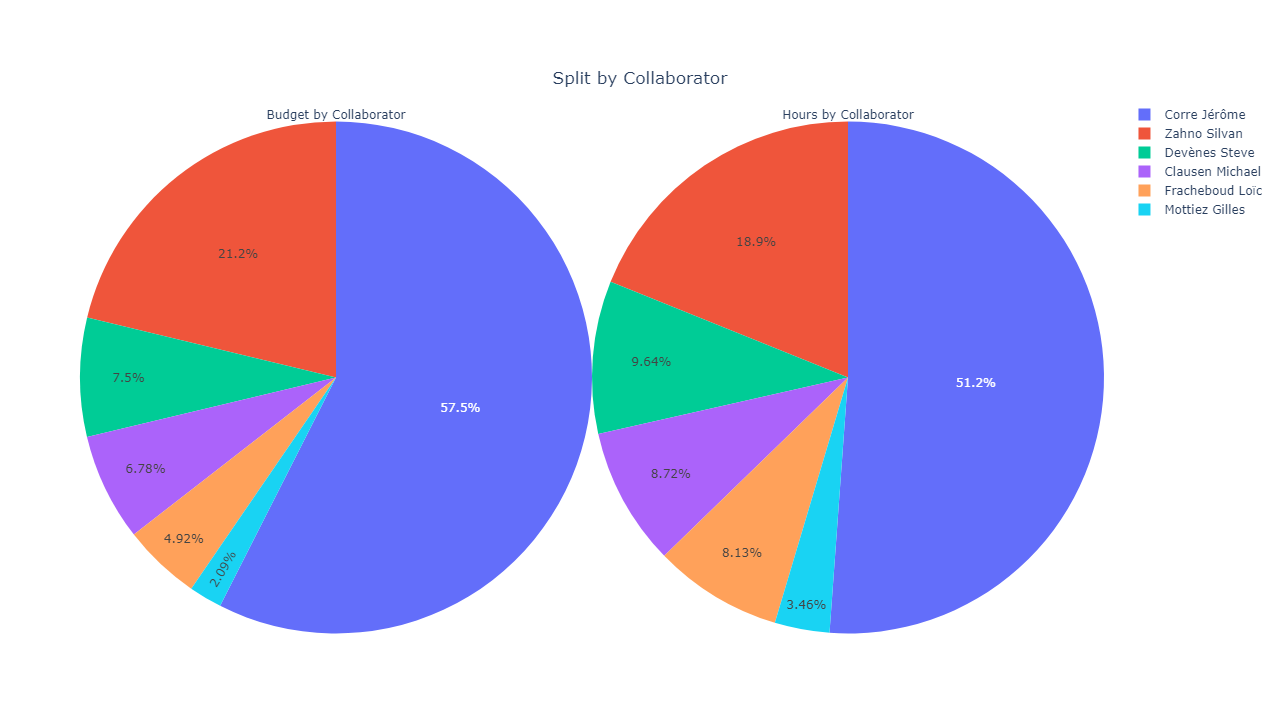

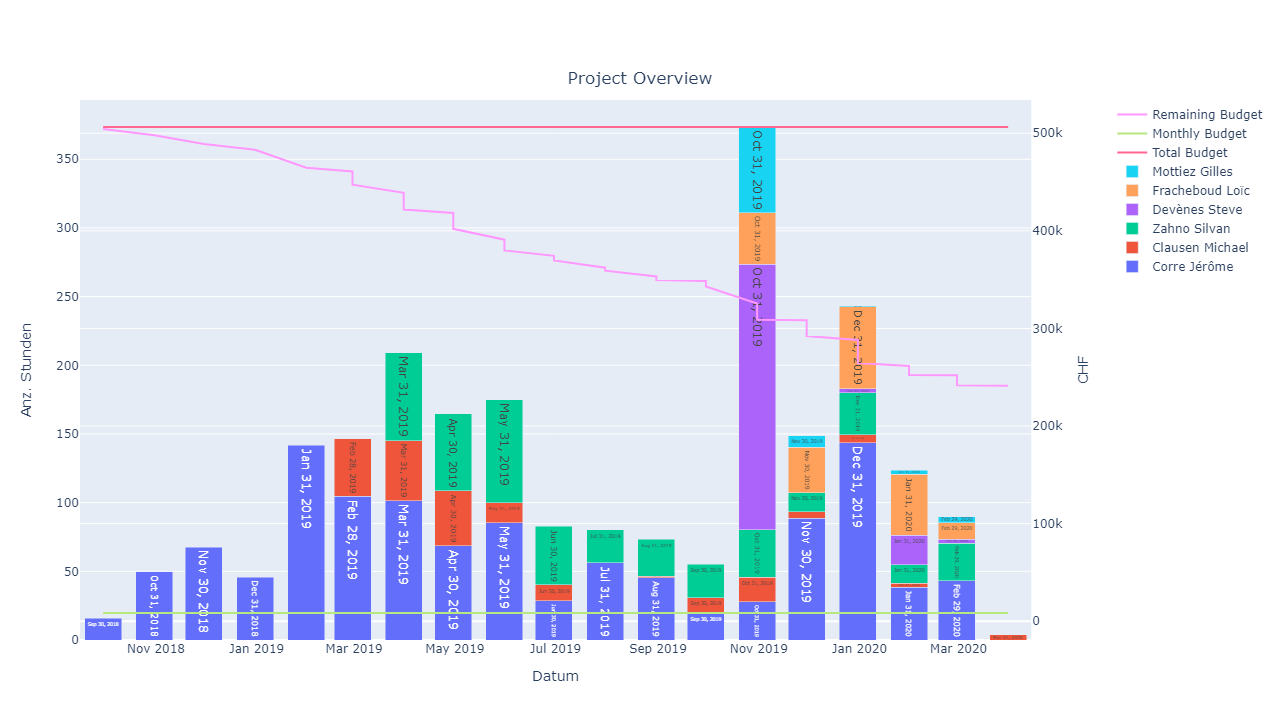

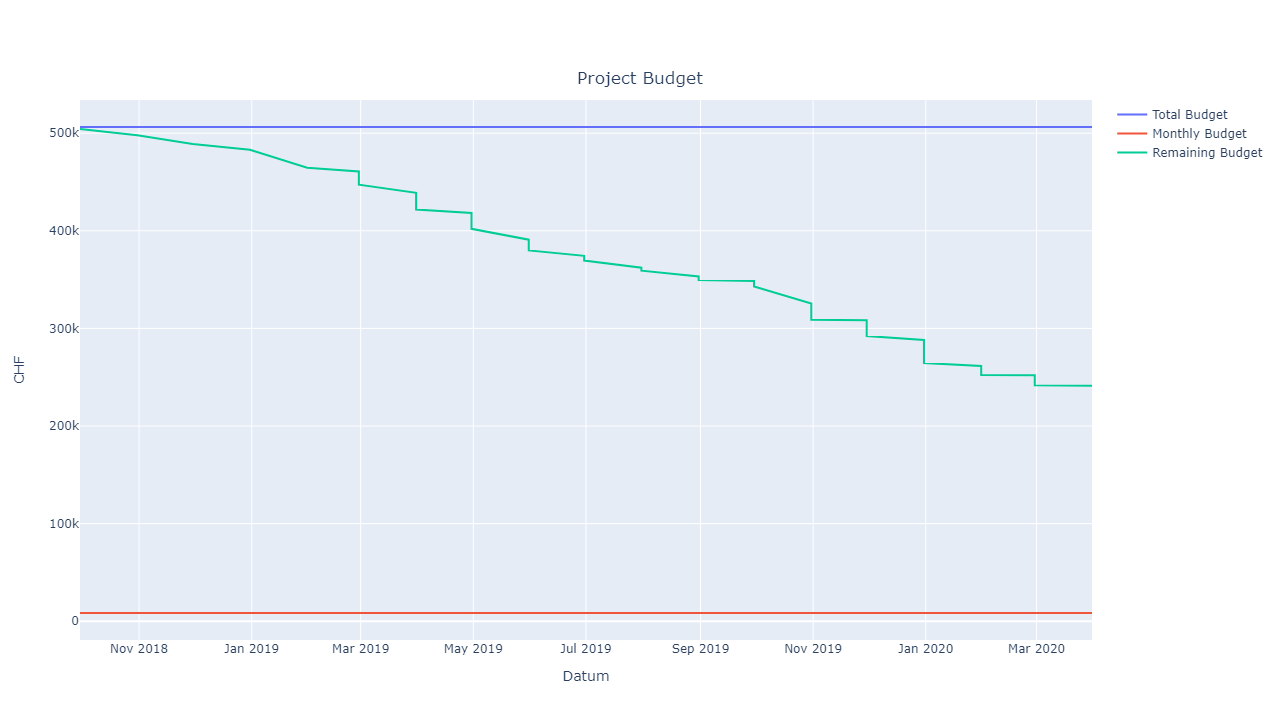

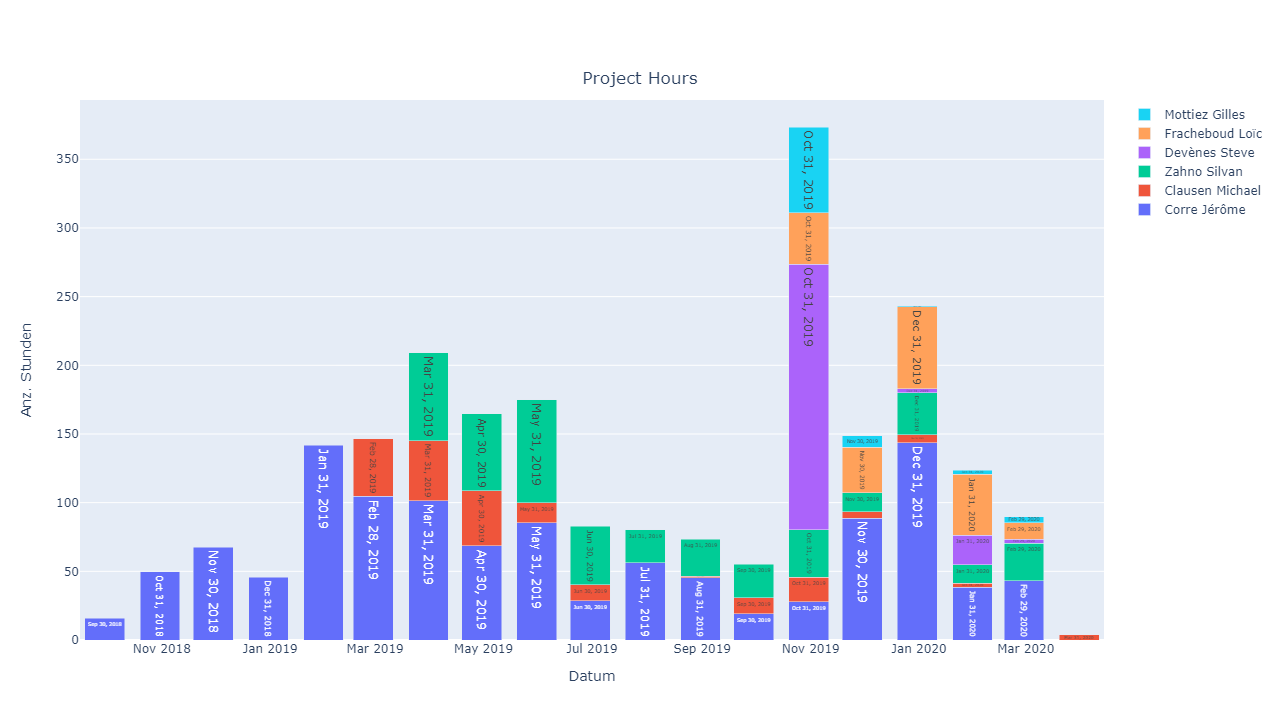

  * PDF Report 89403_SPL_Base.pdf generated
Report created: out\md\89403_SPL_Base.pdf
--------------------------------------------------------------------------
Project Report - 95145 - SPL Personal Development


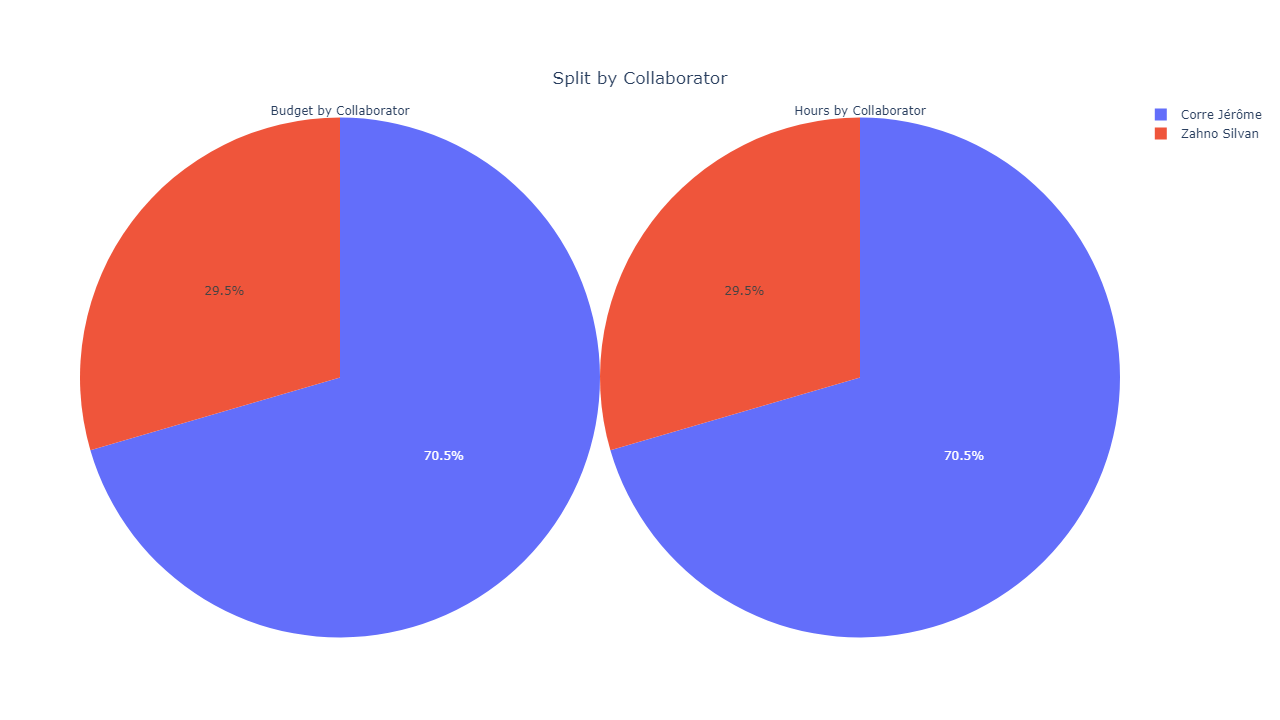

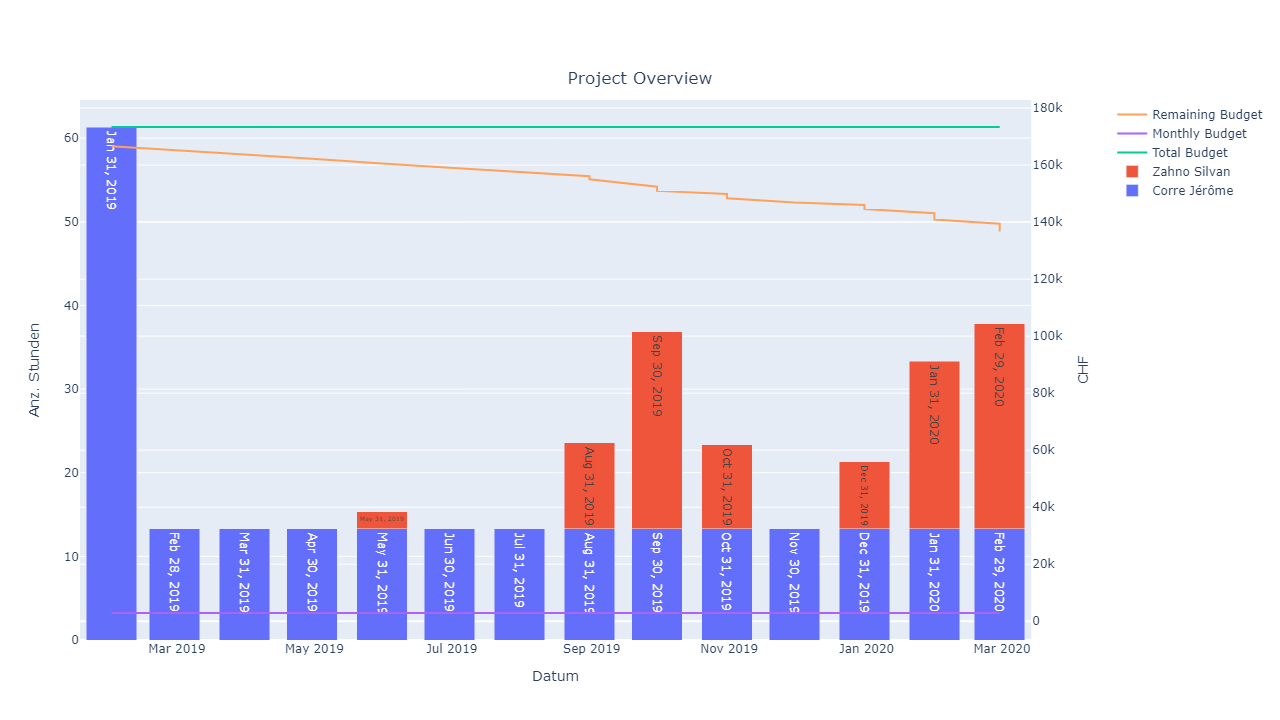

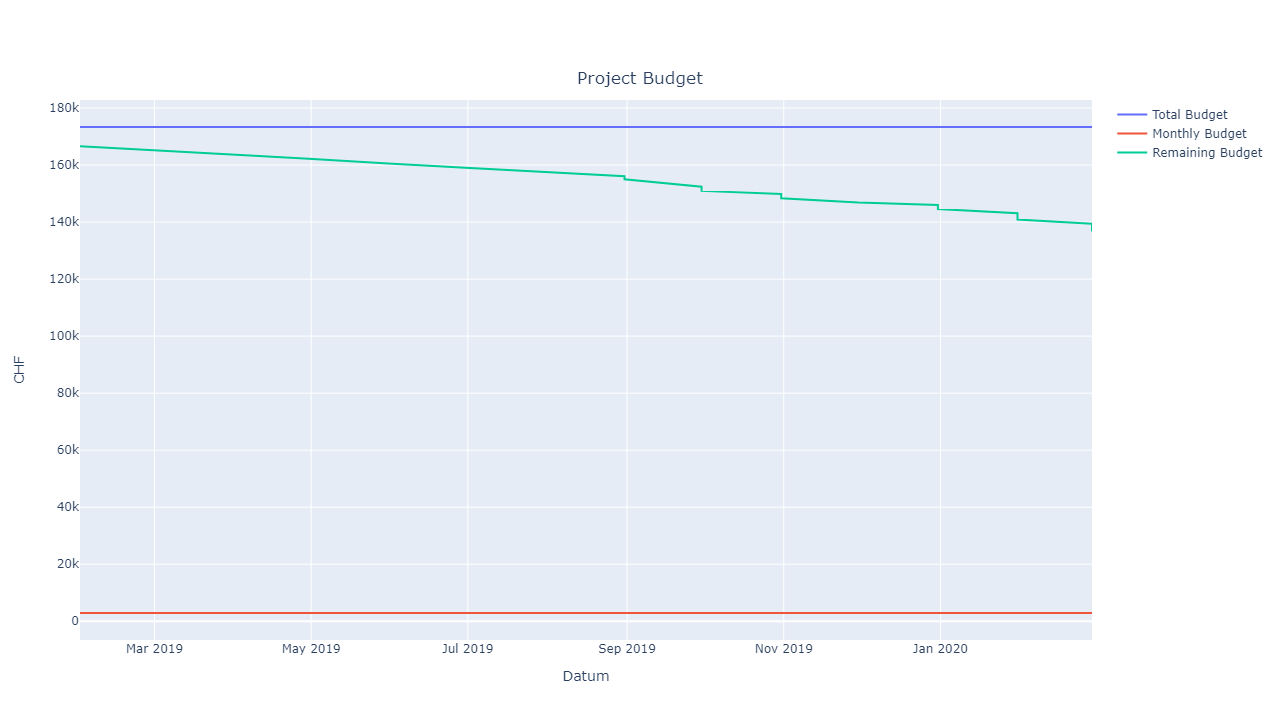

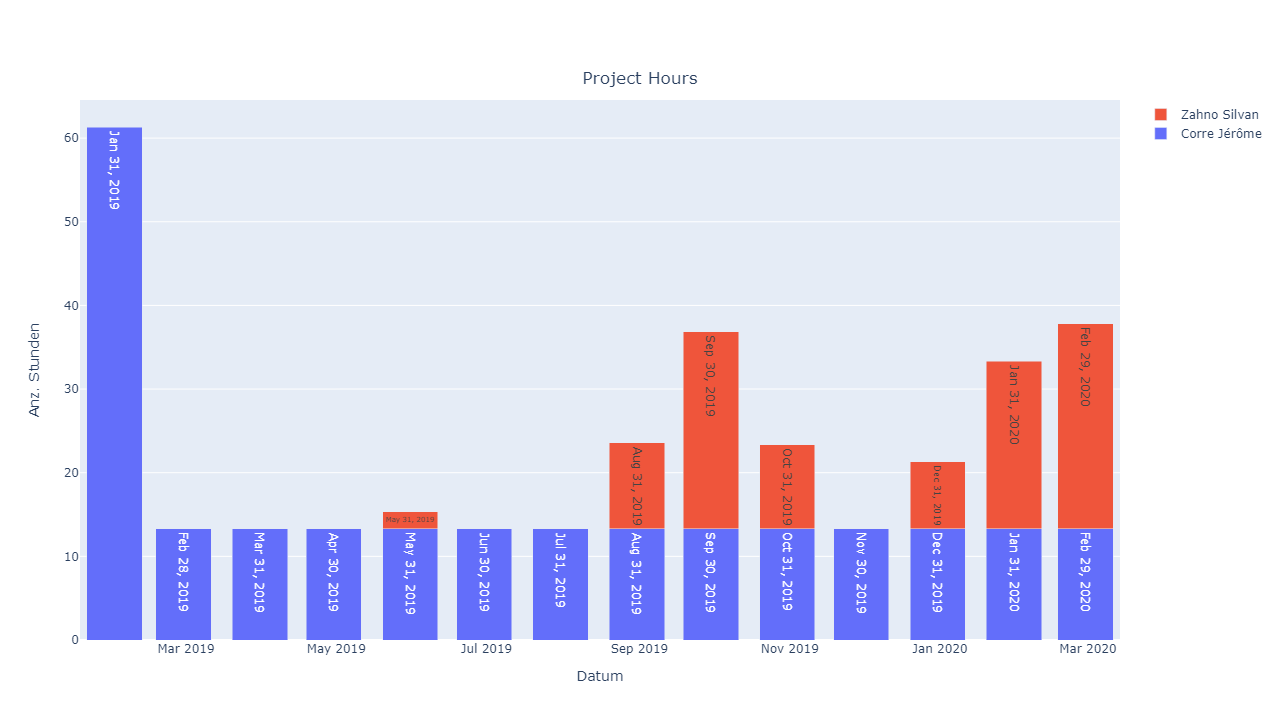

  * PDF Report 95145_SPL_Personal_Development.pdf generated
Report created: out\md\95145_SPL_Personal_Development.pdf
--------------------------------------------------------------------------
Project Report - 95594 - SPL Filiere


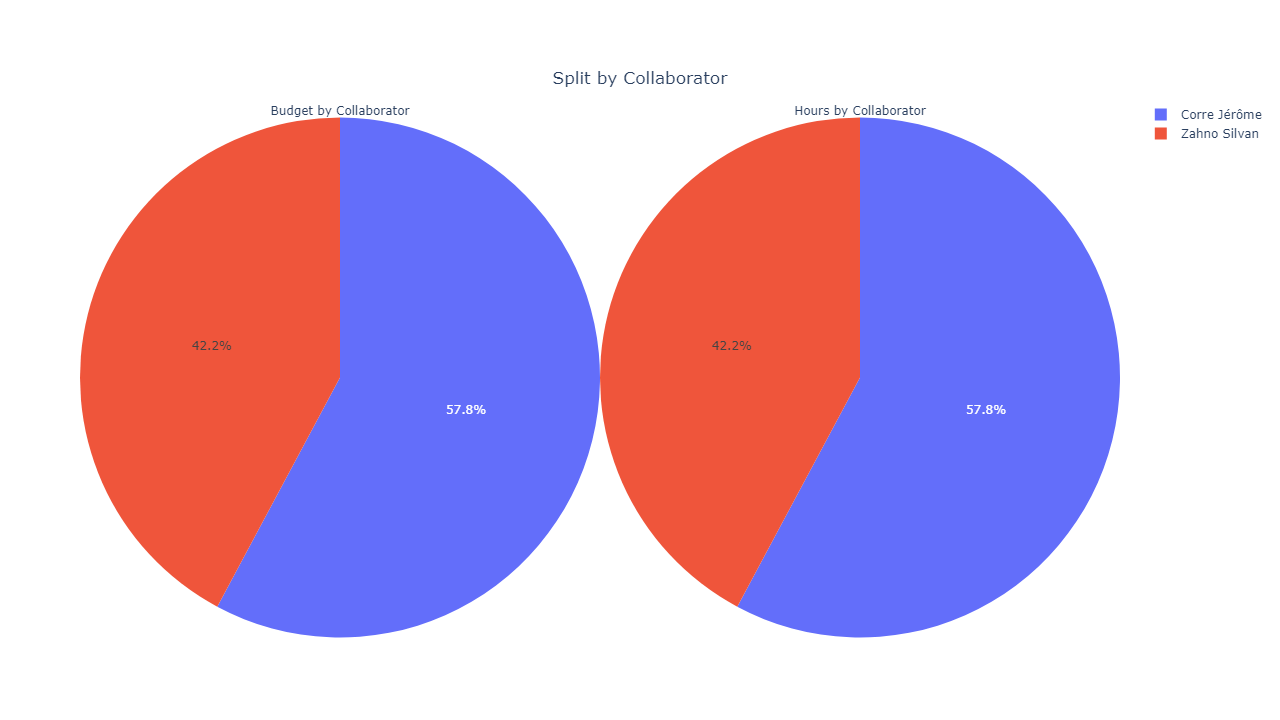

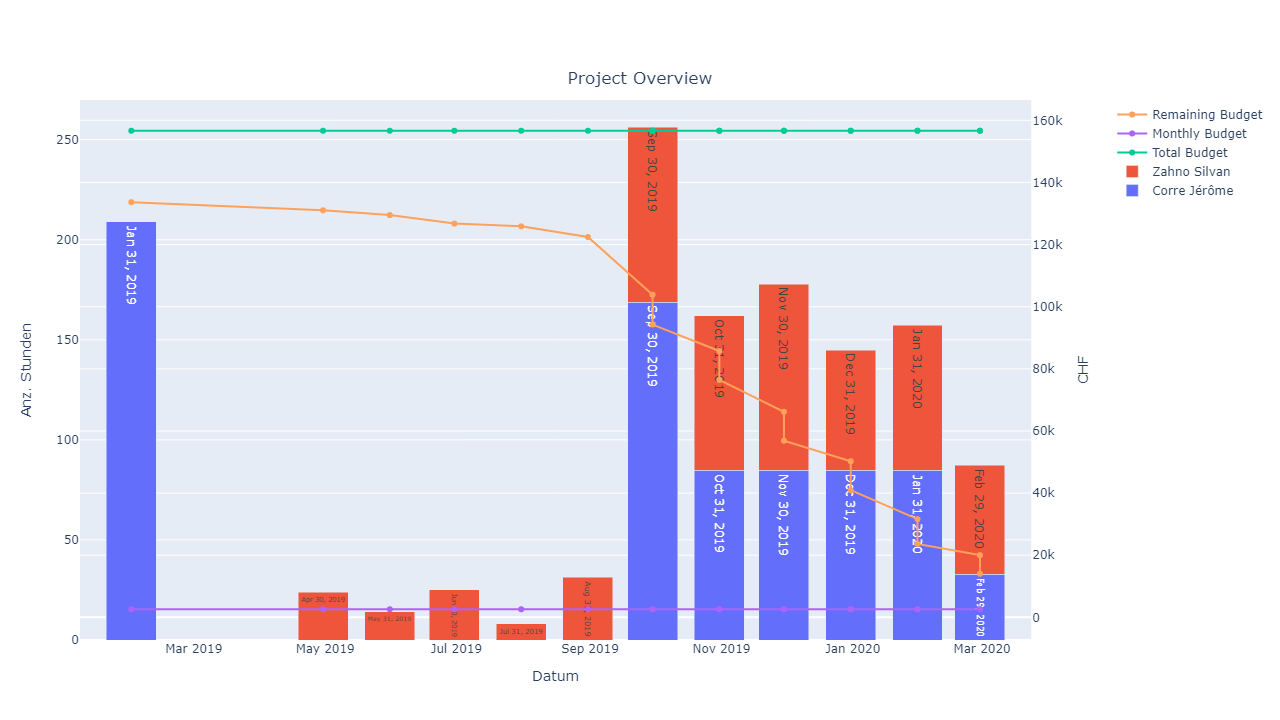

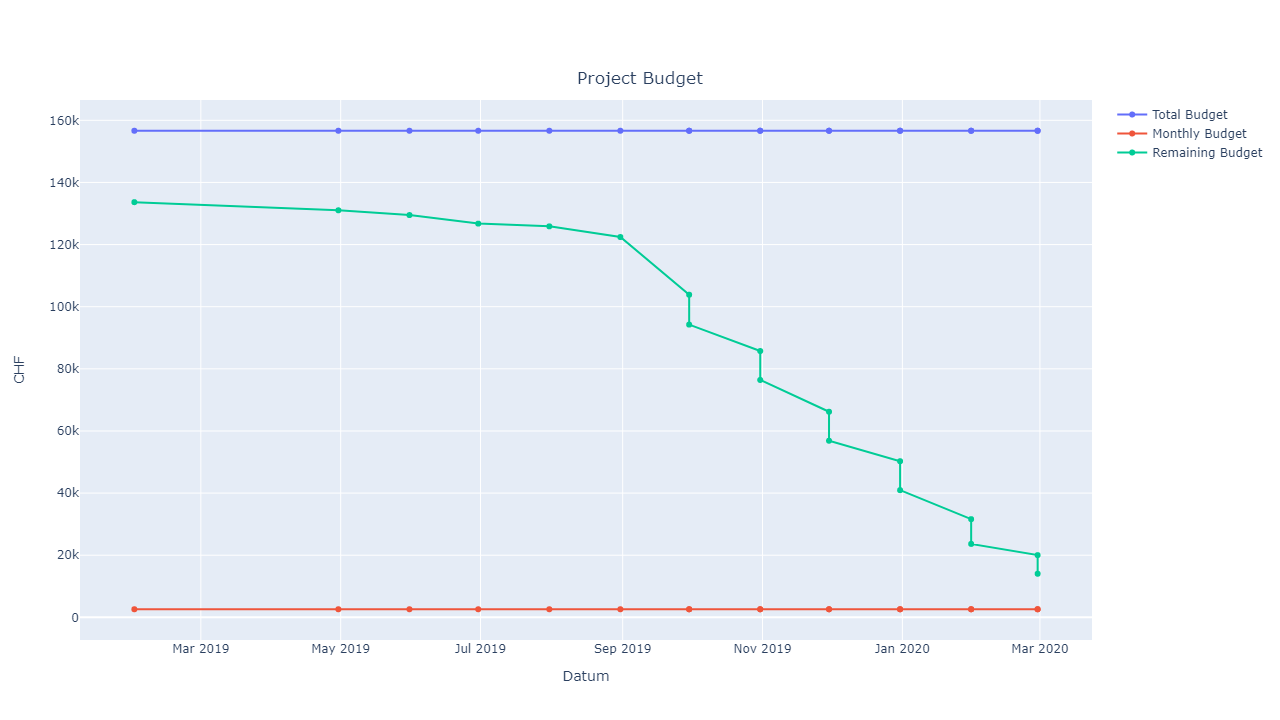

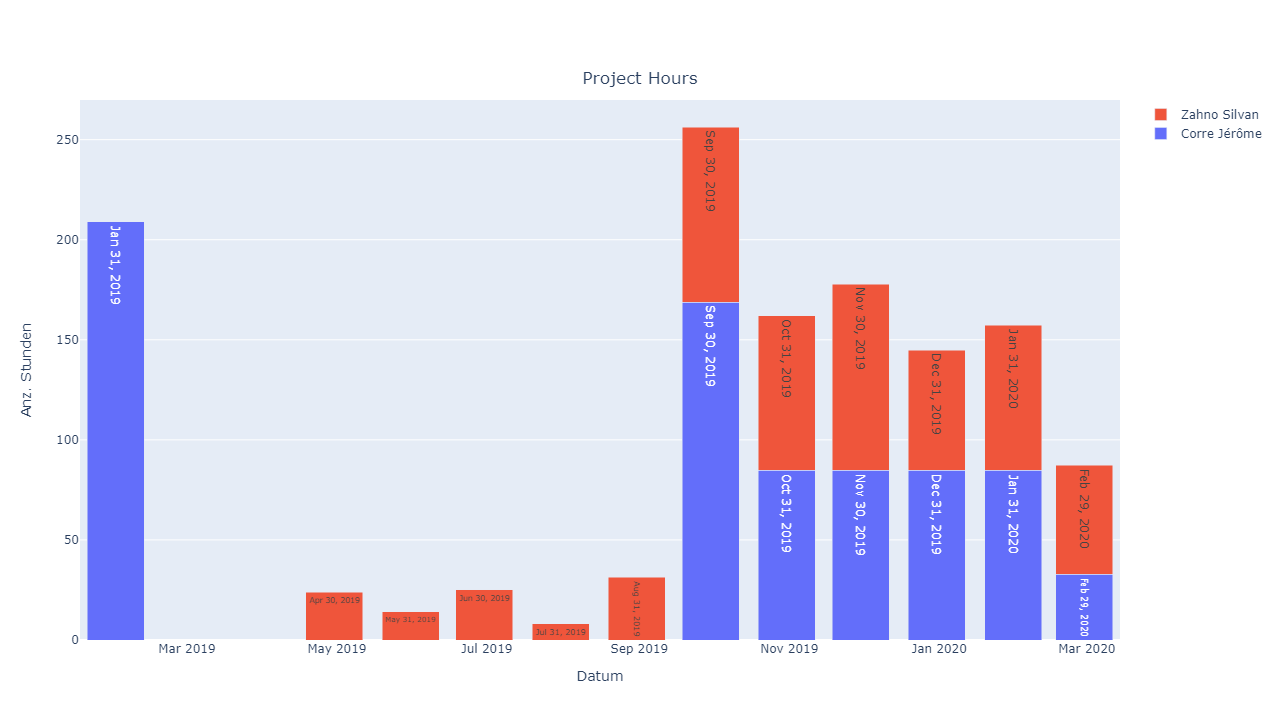

  * PDF Report 95594_SPL_Filiere.pdf generated
Report created: out\md\95594_SPL_Filiere.pdf
--------------------------------------------------------------------------
Project Report - 96201 - Unique Stability Plate


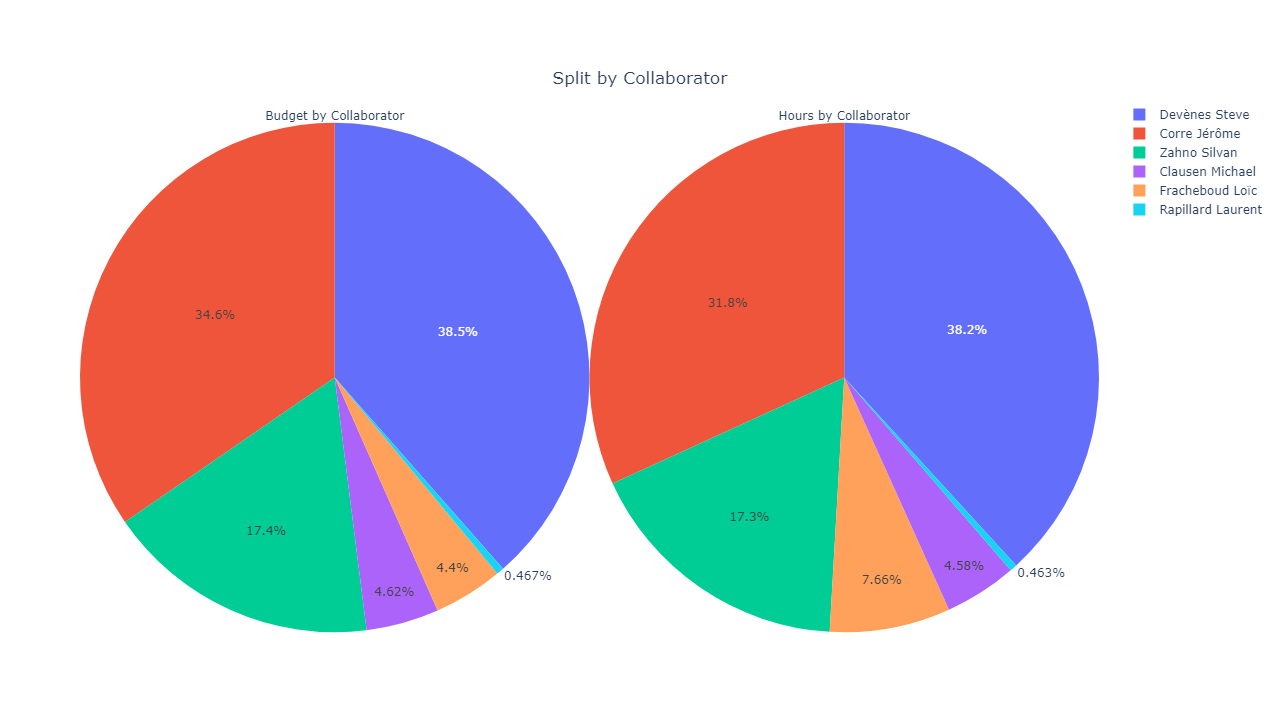

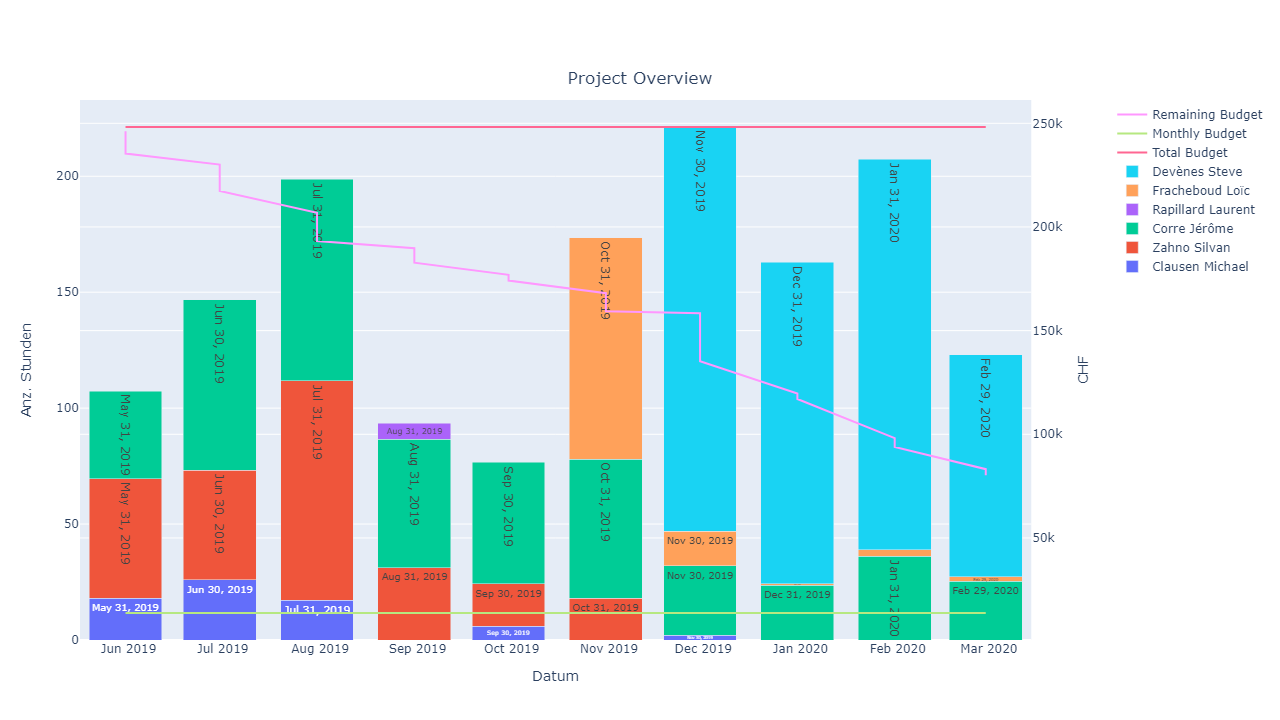

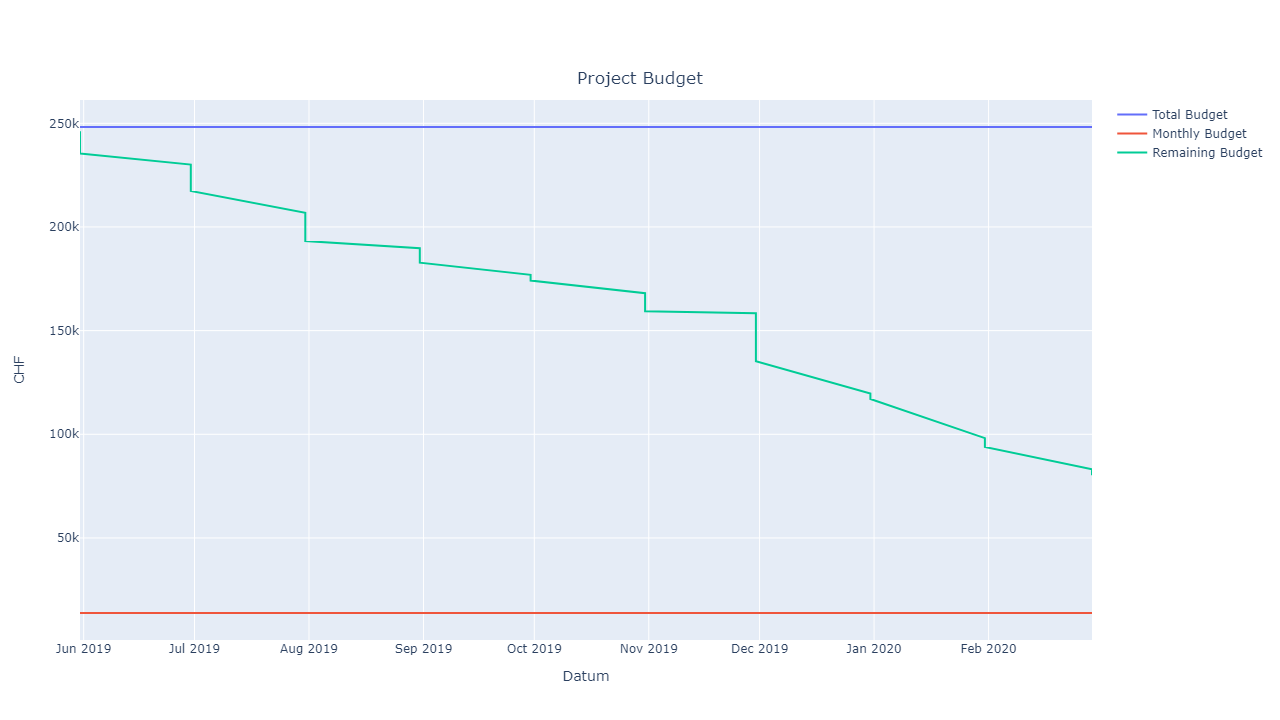

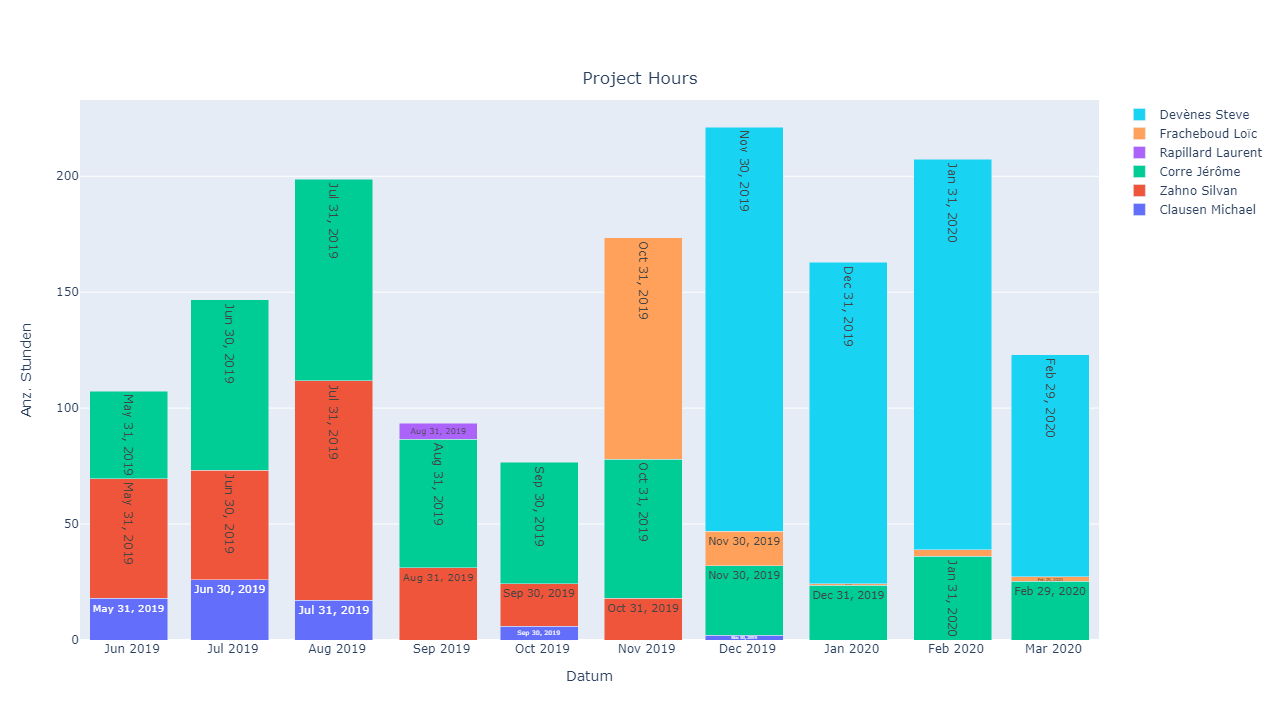

  * PDF Report 96201_Unique_Stability_Plate.pdf generated
Report created: out\md\96201_Unique_Stability_Plate.pdf
--------------------------------------------------------------------------
Project Report - 98568 - Dynamic Production Planning with Digital Twin


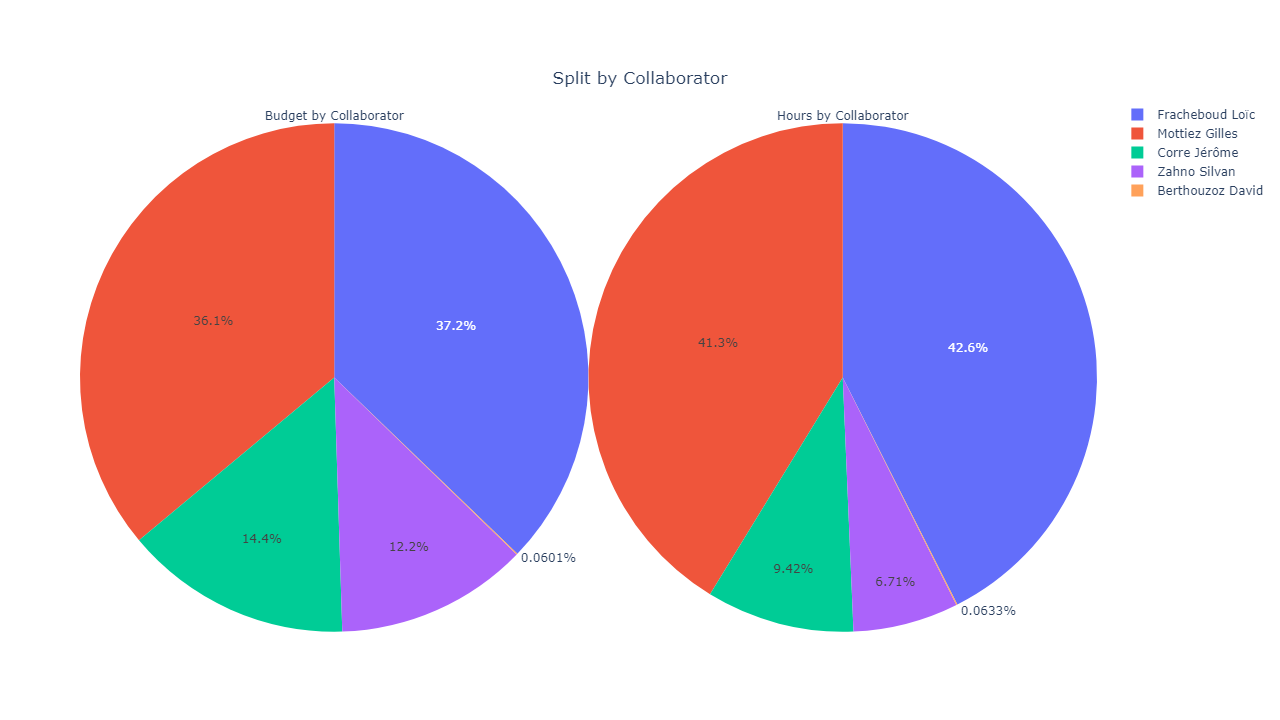

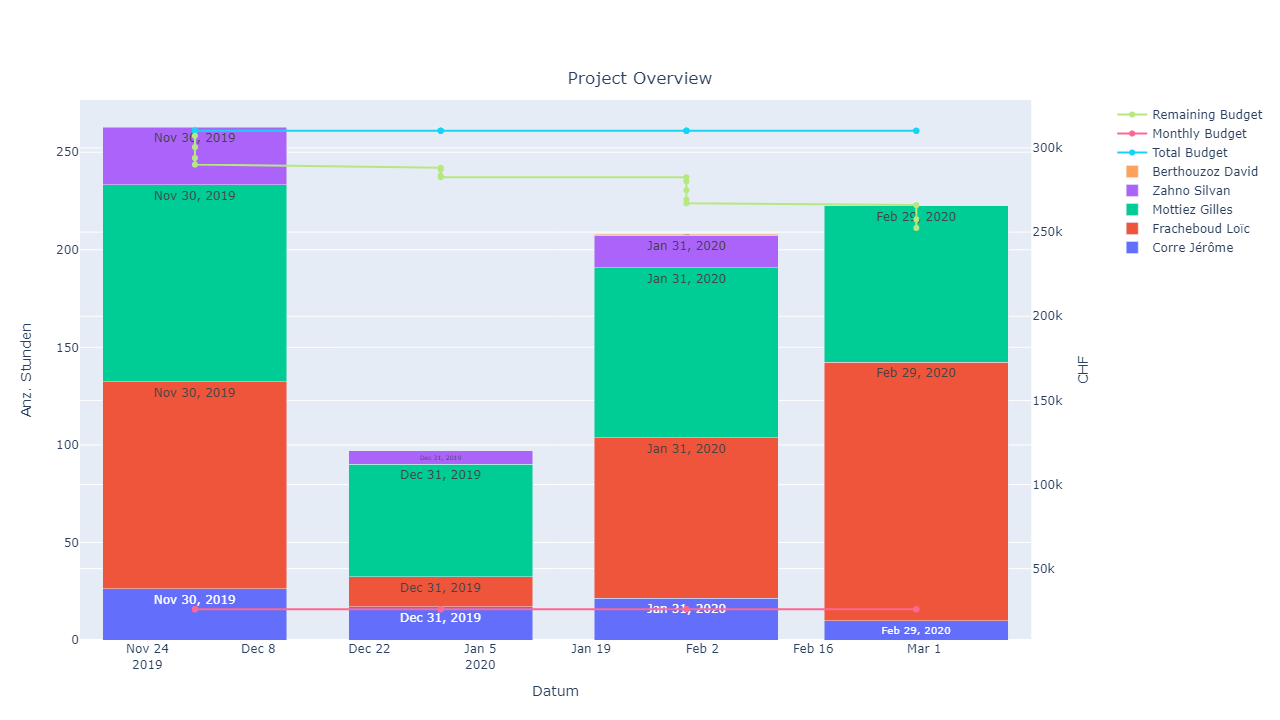

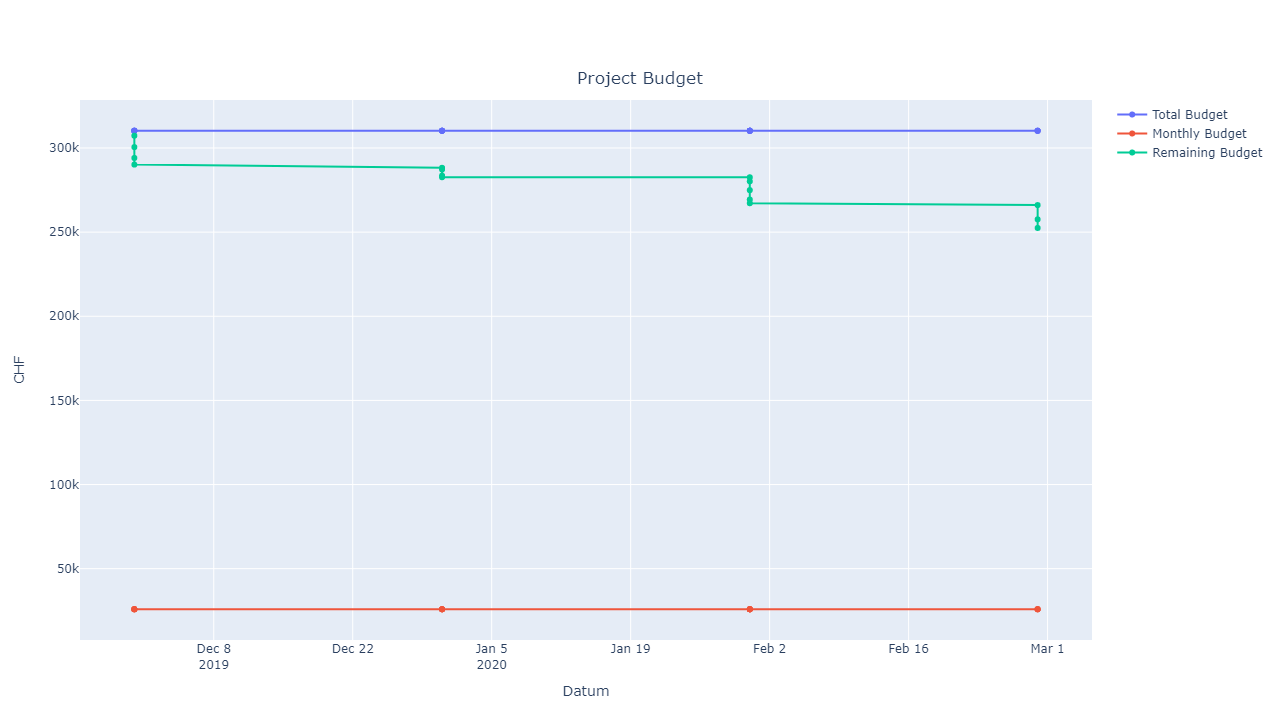

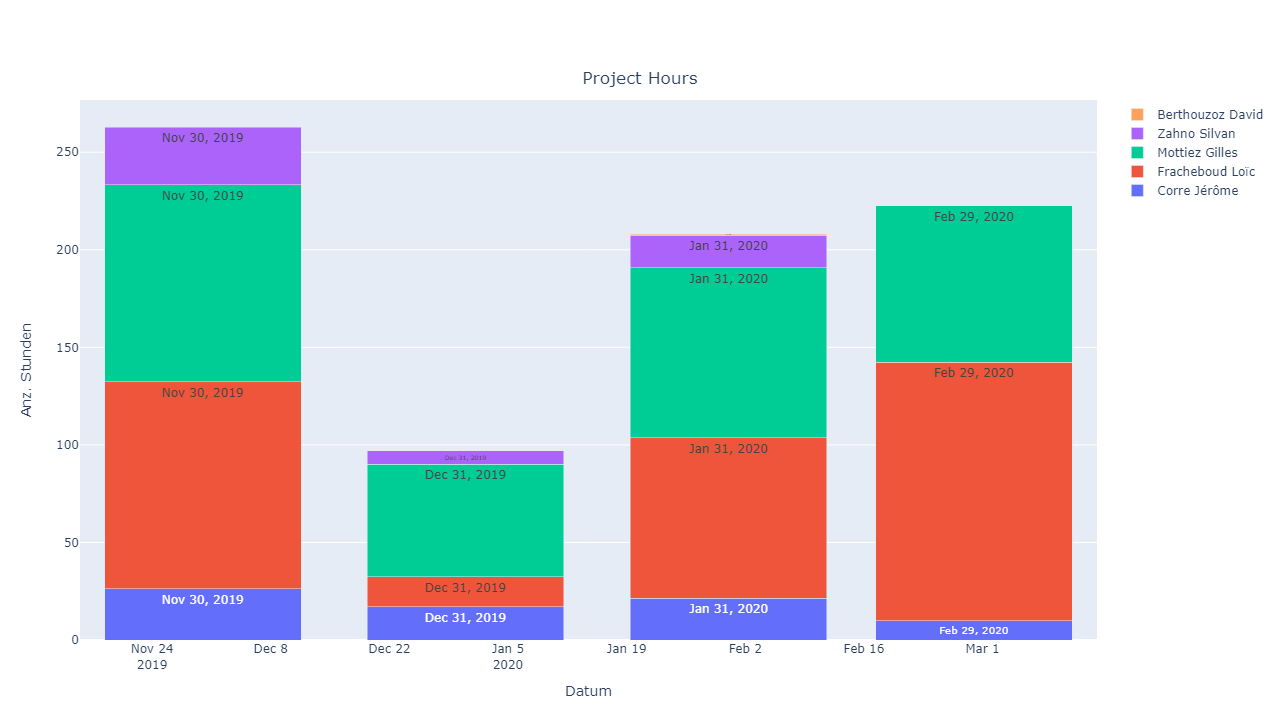

  * PDF Report 98568_Dynamic_Production_Planning_with_Digital_Twin.pdf generated
Report created: out\md\98568_Dynamic_Production_Planning_with_Digital_Twin.pdf
--------------------------------------------------------------------------
Project Report - 98568 - Dynamic Production Planning with Digital Twin


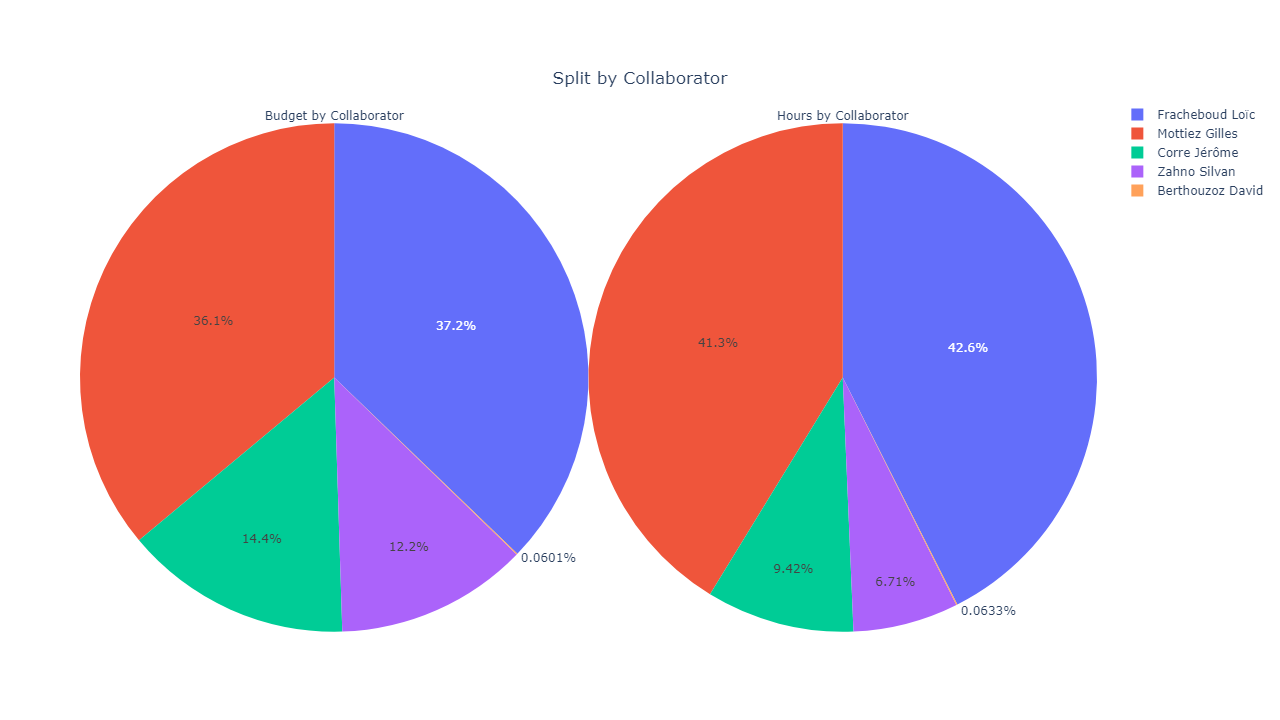

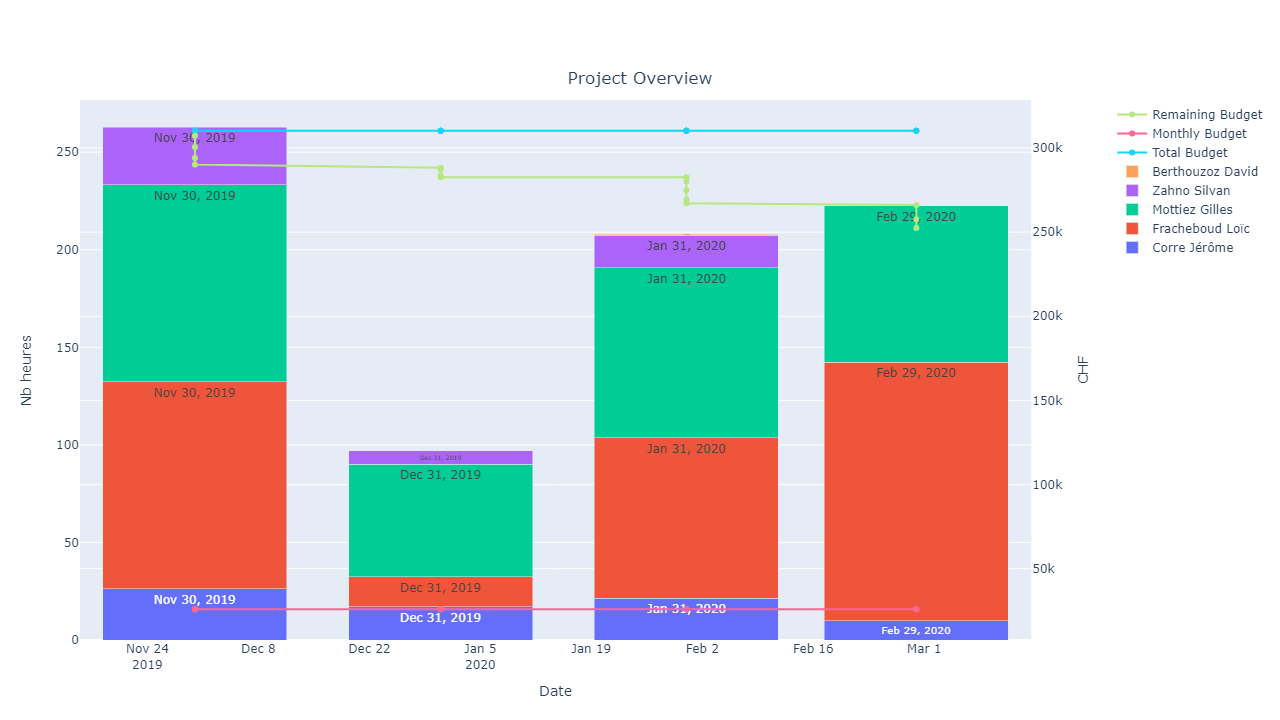

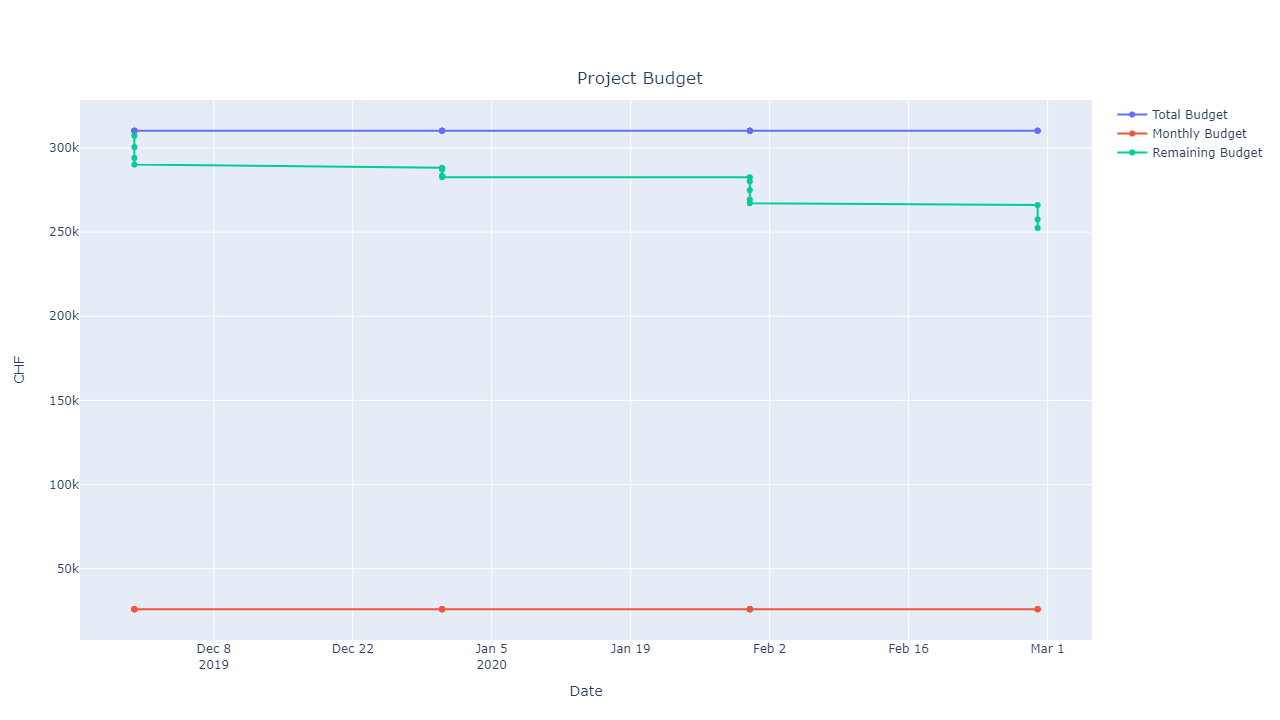

In [ ]:
for i in range(len(projectConfs)):
  projectConf = projectConfs[i]
  aggregated1Df = aggregated1Dfs[i]
  aggregated2Df = aggregated2Dfs[i]
  aggregated3Df = aggregated3Dfs[i]
  ash_col = ashCols[projectConfs[i][1]]
  print("--------------------------------------------------------------------------")
  print("Project Report - {} - {}".format(projectConf[0], filterRows(projectDf, [projectCol["project_number"], [projectConf[0]]])[projectCol["title_humanreadable"]].iloc[0]))
  projectReport(aggregated1Df, aggregated2Df, aggregated3Df, ash_col, projectDf, projectCol, projectConf, outputMdDir, outputDir, verbose)

## Cleanup

In [ ]:
remDir(outputMdDir, verbose)